# Tutorial 4: automatically identify stable cluster resolution module of HRCHY-CytoCommunity on Visium BC dataset
Creator: Runzhi xie (rzxie@stu.xidian.edu.cn).

Affiliation: xidian University, Gao Lab

Date of Creation: 10.10.2025

Date of Last Modification: 10.10.2025

the original expression data could be download from https://www.10xgenomics.com/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0

We use RCTD to deconvolute cell type fraction of each spot


In [23]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
from hrchy_cytocommunity.models.dataset import SpatialOmicsImageDataset
from hrchy_cytocommunity.visualization.visualization import load_base_data, vis_heatmap
from hrchy_cytocommunity.models.auto_k import HRCHYClusterAutoK, _dd_list,_dd_float
import os
import pandas as pd

In [2]:
setting = 'KNN_20'
coarse_range = (2,4)
fine_range = (8,12)
max_nums = 10
data_input_dir = './example_data/VisiumBC'

In [3]:
model_params = {
        'mode' : 'Grand',       # HRCHYCytoCommunity with Grand
        's' : 5,
        'num_epoch' : 1500,
        'alpha' : 0.9,          # loss weight of corase and fine level loss
        'lambda1':1,           # Coefficient of consistency regularization
        'lambda2':1,           # Coefficient of orthogonality loss
        'lambda_balance':1,
        'edge_pruning_cutoff' :  None,       # edge pruning cutoff
        'num_hidden' : 128,     # the dimension of hidden layer
        'lr' : 1e-4,
        'drop_rate' : 0.5,
        'temp': 1,
        'gt_fine':False,
        'gt_coarse':False,
        'device':'cuda:2'
        }

## Cluster Stability to identify optimal resolution of hierarchical tissue structure

/home/runzhixie/miniforge3/envs/HRCHY-CytoCommunity/lib/python3.10/site-packages/hrchy_cytocommunity/models/dataset.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self

V1_Breast_Cancer_Block_A_Section_1 is processing


精细聚类数量:   0%|          | 0/5 [00:00<?, ?it/s]

精细聚类数量: 100%|██████████| 5/5 [00:00<00:00, 31726.96it/s]


loading 2 and 8 clustering results
loading 2 and 9 clustering results
loading 2 and 10 clustering results
loading 2 and 11 clustering results
loading 2 and 12 clustering results


精细聚类数量: 100%|██████████| 5/5 [00:00<00:00, 33288.13it/s]


loading 3 and 8 clustering results
loading 3 and 9 clustering results
loading 3 and 10 clustering results
loading 3 and 11 clustering results
loading 3 and 12 clustering results


粗聚类数量: 100%|██████████| 3/3 [00:00<00:00, 270.70it/s]


loading 4 and 8 clustering results
loading 4 and 9 clustering results
loading 4 and 10 clustering results
loading 4 and 11 clustering results
loading 4 and 12 clustering results


粗聚类数量: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


            fine_8    fine_9   fine_10   fine_11   fine_12
coarse_2  0.599596  0.651553  0.617034  0.296808  0.306313
coarse_3  0.553968  0.530714  0.561042  0.562880  0.564140
coarse_4  0.588096  0.594445  0.596038  0.620920  0.580811


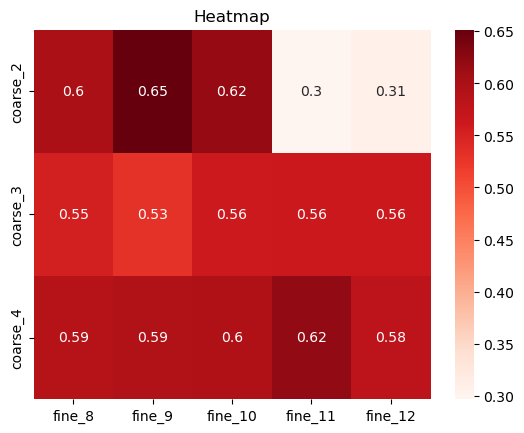

In [5]:
dataset = SpatialOmicsImageDataset(data_input_dir)
ret_output_dir0 = './results/VisiumBC'
graph_dict = {
    'V1_Breast_Cancer_Block_A_Section_1': 0 # fill graph of this dataset
}
for slice_name,graph_idx in graph_dict.items():
    print(f"{slice_name} is processing")
    train_dataset = dataset[graph_idx]
    cell_meta = load_base_data(os.path.join(data_input_dir,'raw'),graph_idx,is_single_cell=False)
    save_dir = os.path.join(ret_output_dir0,'autok_test',slice_name)
    hrchy_autok = HRCHYClusterAutoK(
        dataset=train_dataset,
        cell_meta=cell_meta,
        coarse_range=coarse_range,
        fine_range=fine_range,
        model_params=model_params,
        max_runs=max_nums,
        # vis_while_training= True
    )
    hrchy_autok.fit(save_dir=save_dir)
    hrchy_autok.save(save_dir=os.path.join(save_dir,'autok_output'))
    # hrchy_autok.load(save_dir=os.path.join(save_dir,'autok_output'))
    stability_mat = hrchy_autok.convert_stability_2_mat()
    print(stability_mat)
    vis_dir = os.path.join(ret_output_dir0,'autok_output')
    if not os.path.exists(vis_dir): 
        os.makedirs(vis_dir)
    vis_heatmap(stability_mat,save_path=os.path.join(vis_dir,f'{slice_name}_heatmap.png'))

### the result show that best coarse=2, fine=9

In [ ]:
import scanpy as sc
best_fine_k = 9
best_coarse_k = 2
best_fine,best_coarse = hrchy_autok.find_best_model(save_dir=os.path.join(save_dir),num_coarse=best_coarse_k,num_fine=best_fine_k)
cell_meta['fine_cluster'] = best_fine
cell_meta['coarse_cluster'] = best_coarse
adata = sc.read_h5ad(f"{data_input_dir}/ad_sp_raw.h5ad")
adata.obs['fine_cluster'] = best_fine
adata.obs['coarse_cluster'] = best_coarse

/home/runzhixie/miniforge3/envs/HRCHY-CytoCommunity/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
coarse_color_dict = {
    '0': '#d70000','1': '#028800',
}
fine_color_dict = { '1': '#ff7fd1',
                    '6': '#8c3cff',
                    '8': '#028800',
                    '5': '#9CC826', 
                    '0': '#d70000',
                    '4': '#6c004f', 
                    '2': '#ffa530',
                    '7': '#00009d',
                    '3': '#4f2a00'
                 }

## Visualize cluster ret

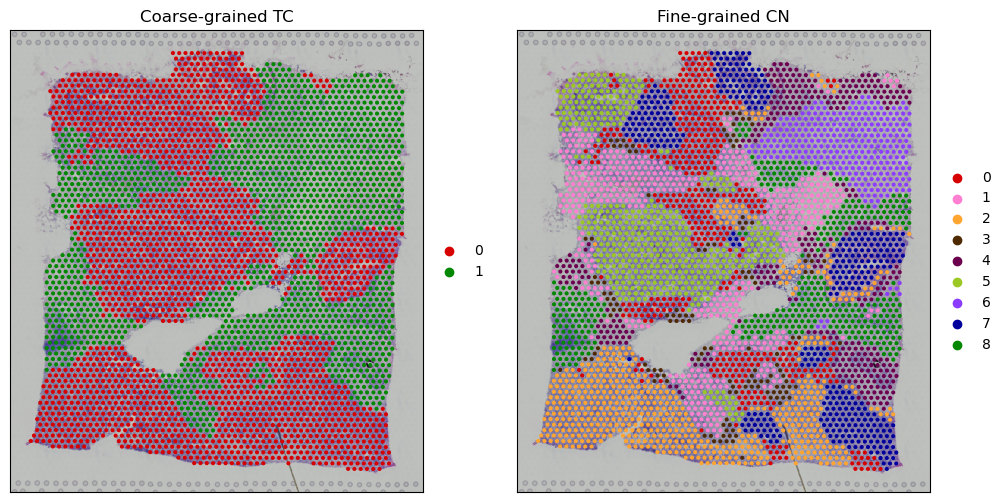

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

adata.obs['coarse_cluster'] = adata.obs['coarse_cluster'].astype('str')
adata.obs['fine_cluster'] = adata.obs['fine_cluster'].astype('str')
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sc.pl.spatial(adata,color='coarse_cluster',palette=coarse_color_dict,ax =axes[0],show=False)
axes[0].set_title("Coarse-grained TC")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)
sc.pl.spatial(adata,color='fine_cluster',palette=fine_color_dict,ax =axes[1],show=False)
axes[1].set_title("Fine-grained CN")
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
plt.show()
